In [1]:
import os
import sys

import pandas as pd

## First let's look at our dataset and determine how it should be split up

In [4]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [2]:
## Let's make a directory within datasets to store all our files
# Choose a short string 3-5 characters to denote this particular dataset
# For this one, I chose "ribo" for the ribosomal rna.
# Make sure to set "focus" in datatype as the same string

dataset_focus = "cov"
dataset_dir = f"./{dataset_focus}/"

if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)

In [2]:
# Let's import our data_prep tools
import data_prep as dp

In [7]:
# The below code can take awhile to run depending on the size of each file
cov_df = dp.process_raw_fasta_files("r1.txt", "r2.txt", "r3.txt", "r4.txt", "r5.txt", "r6.txt", "r7.txt", "r8.txt", "r9.txt", "r10.txt", "r11.txt", "r12.txt", in_dir="/mnt/D1/sars-cov-2-data/processed/", out_dir=dataset_dir, violin_out="cov_data_lengths", input_format="fasta")

Observed Characters: ['C', 'A', 'N', 'G', 'T']


In [ ]:
for round in [f"r{x}" for x in range(1, 13)]:
    if x > 2:
        rseqs = cov_df[cov_df["round"] == round]

In [3]:
sys.path.append("../rbm_torch/")
import utils

## Looking at the above graph + the length report in our out directory we see this

<img src="./cov/cov_data_lengths.png" alt="COV Data Lengths" style="height: 50px; width:50px;"/>

In [3]:
!cat ./cov/r5_len_report.txt

Removed 3036794 Repeat Sequences
Length: 19 Number of Sequences 1
Length: 25 Number of Sequences 2
Length: 27 Number of Sequences 2
Length: 28 Number of Sequences 2
Length: 29 Number of Sequences 6
Length: 30 Number of Sequences 29
Length: 31 Number of Sequences 59
Length: 32 Number of Sequences 74
Length: 33 Number of Sequences 108
Length: 34 Number of Sequences 125
Length: 35 Number of Sequences 286
Length: 36 Number of Sequences 546
Length: 37 Number of Sequences 1280
Length: 38 Number of Sequences 5464
Length: 39 Number of Sequences 12615
Length: 40 Number of Sequences 2078863
Length: 41 Number of Sequences 162432


In [ ]:
# So now we can define our datatype

# Datatype defines the basics of our data, Each datatype is specified for a group of related fasta files
# Focus - > short string specifier that gives the overall dataset we are using
# Molecule -> What kind of sequence data? currently protein, dna, and rna are supported
# id -> short string specifier ONLY for datasets which have different clustering methods (CLUSTERS ONLY)
# process -> How were the gaps added to each dataset, used to name directory (CLUSTERS ONLY)
# clusters -> How many clusters are in each data file (1 if no clusters)
# cluster_indices -> Define the lengths of data put in each cluster, It is inclusive so [12, 16] includes length 12 and length 16. There must be cluster_indices for each cluster
# gap_position_indices -> Index where gaps should be added to each sequence that is short of the maximum length. (-1 means add gaps to the end of the clusters)

cov_datatype = {"focus": "cov", "molecule": "dna", "id": None, "process": None, "clusters": 1, "gap_position_indices": [-1], "cluster_indices": [[40, 40]]}

## Before we do anything else, we need to copy our datatype to phage_display_ML/rbm_torch/analysis/global_info.py
## Also make sure to add the new datatype to the datatype_list in the same file.

## Next we need to process the raw files and make our own fasta files with our preferred formatting

In [7]:
# chars_to_remove = ["W", "D", "V", "M", "B", "R", "K", "Y", "H", "S"]
# chars_replace = {x: "-" for x in chars_to_remove}
dp.prepare_data_files("cov", cov_df, target_dir=dataset_dir, character_conversion={"T": "U", "N":"-"}, remove_chars=None) # Creates datafiles in target directory

## Now we have generated a data file that we can use for training our RBM or CRBM

#We will also try scaling the weights based off other information. In this case I am going choose a weight that is representative of both the copy number and the number of sequences that match with less than a threshold of difference b/t one another. To do this I'm going to read in the already processed files with their count number. And write them out with the altered weights in the fasta file

In [ ]:
import numpy as np

#### The Below Scaling Weights didn't work too well, returned about the same model as just the raw weights

In [ ]:
## Scaling all Rounds except R1 and R2 (way too much data, pairwise neighbor jobs aren't done yet)

In [3]:
fasta_file = "r3.fasta"
dp.scale_weights(f"./cov/{fasta_file}", "./cov/sw/", f"./cov/{fasta_file}_15_neighbor_counts.pkl", molecule="dna", threads=12, precision=20, scale_log=True, copynum_coeff=5.0, neighbor_coeff=0.5, normalize_threshold=0.75)

Process Time 0.587090015411377


In [4]:
import rbm_torch.utils as utils
import data_prep as dp
import numpy as np

In [5]:
all_fasta_files = [f"r{i}.fasta" for i in range(3, 13)]
all_affinities =[]
min_vals = []
for fasta_file in all_fasta_files:
    seqs, affs, chars, q = utils.fasta_read(f"./cov/{fasta_file}", "dna", threads=12)
    # stand_affs = dp.standardize_affinities(affs, out_plot=f"./cov/sw/{fasta_file.split('.')[0]}_stand_affs")
    stand_affs = dp.standardize_affinities(affs, out_plot=f"./cov/nw/{fasta_file.split('.')[0]}_stand_affs")
    min_vals.append(min(stand_affs))
    all_affinities.append(stand_affs)
    # neighs = dp.load_neighbor_file(f"./cov/{fasta_file}_15_neighbor_counts.pkl")
    # neighs_log_scaled = dp.scale_values_np(dp.log_scale(neighs, base=0.001), min=0.01, max=1.00)
    # dp.quick_hist(neighs_log_scaled.squeeze(1).tolist(), outfile=f"./cov/sw/{fasta_file.split('.')[0]}_neighs_log_scaled")
    # new_weights = np.asarray(stand_affs) * neighs_log_scaled.squeeze(1)
    # dp.quick_hist(new_weights.tolist(), outfile=f"./cov/sw/{fasta_file.split('.')[0]}_aff_and_neigh_weights")
    # dp.make_weight_file(f"./cov/nw/{fasta_file.split('.')[0]}_nw_weights", stand_affs, "nw")
    # dp.write_fasta(seqs, stand_affs, f"./cov/nw/{fasta_file}")
    # dp.write_fasta(seqs, new_weights.tolist(), f"./cov/sw/{fasta_file.split('.')[0]}_n")

Process Time 0.5592570304870605
Process Time 0.3178377151489258
Process Time 1.5709872245788574
Process Time 1.1642749309539795
Process Time 2.1850874423980713
Process Time 0.6264688968658447
Process Time 0.16741061210632324
Process Time 0.41866111755371094
Process Time 0.20952653884887695
Process Time 0.4487771987915039


In [6]:
thresholds = min_vals
for fid, fasta_file in enumerate(all_fasta_files):
    new_weights =dp.negate_affinites(all_affinities[fid], thresholds[fid], out_plot=f"./cov/nw/{fasta_file.split('.')[0]}_n3_affs", negative_factor=10000.)
    dp.make_weight_file(f"./cov/nw/{fasta_file.split('.')[0]}_n3_weights", new_weights, "n3")
    # dp.write_fasta(seqs, stand_affs, f"./cov/nw/{fasta_file}")

In [134]:
import numpy as np
r9_neighs_log = log_scale(r9_neighs_close)   # Want largest value to be least number of neighbors (1)

10.035655516113545 0.6931471805599453 6.73164957580278 7.848543482456679


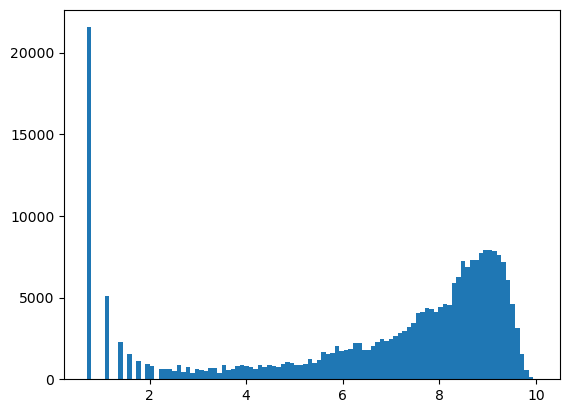

In [135]:
summary(r9_neighs_log)
quick_hist(r9_neighs_log)

In [140]:
from sklearn.preprocessing import MinMaxScaler

mscaler = MinMaxScaler(feature_range=(0.05, 0.95))
r9_scaled = mscaler.fit_transform(r9_neighs_log.reshape(-1, 1))

0.95 0.05 0.6317123154213931 0.7393070298048023


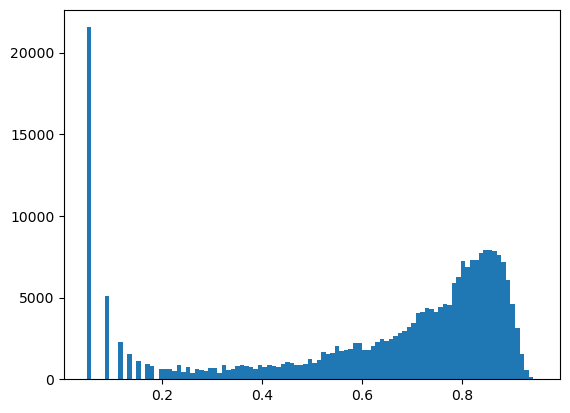

In [141]:
summary(r9_scaled)
quick_hist(r9_scaled)

334668.0 1.0 8.113757120779015 1.0


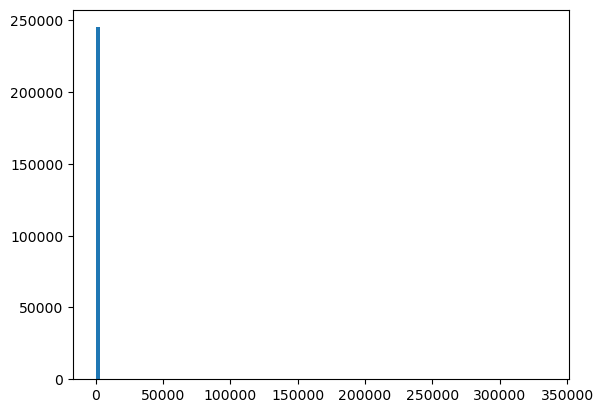

In [142]:
affs = np.asarray(affs)
summary(affs)
quick_hist(affs)

12.72089726265295 0.6931471805599453 0.8867362142919959 0.6931471805599453


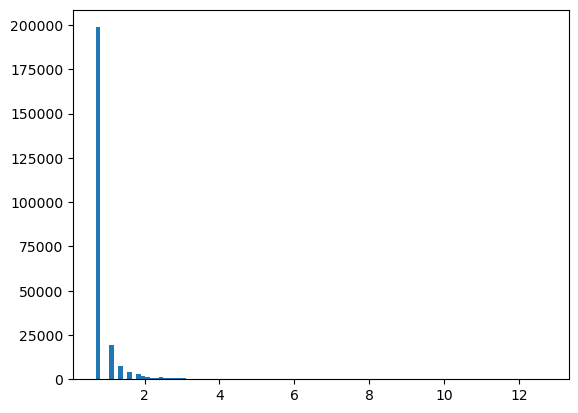

In [144]:
log_affs = log_scale(affs)
summary(log_affs)
quick_hist(log_affs)

0.95 0.05 0.06448567929743075 0.05


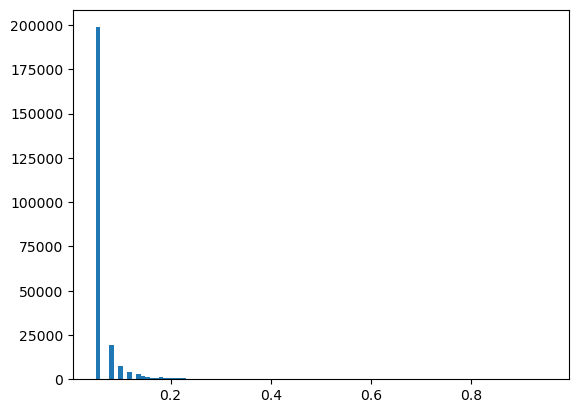

In [146]:
ascaler = MinMaxScaler(feature_range=(0.05, 0.95))
affs_scaled = ascaler.fit_transform(log_affs.reshape(-1, 1))

summary(affs_scaled)
quick_hist(affs_scaled)

0.3348448080826318 0.003307718667520332 0.022179787810108074 0.015061535530508603


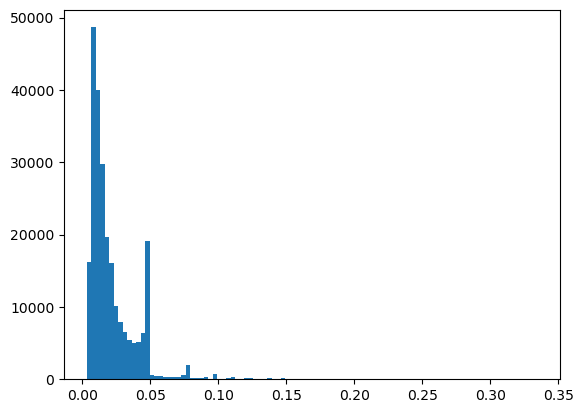

In [147]:
new_weights = affs_scaled*(1-r9_scaled)
summary(new_weights)
quick_hist(new_weights)

In [157]:
import pandas as pd
neigh_term = 1-r9_scaled
weight_df = pd.DataFrame({"weights": new_weights.tolist(), "affs": affs_scaled.tolist(), "neigh": neigh_term.tolist()})
weight_df.sort_values("weights", ascending=True, inplace=True)
weight_df.head(20)

,weights,affs,neigh
91184,[0.003307718667520332],[0.05],[0.06615437335040664]
186376,[0.003470392537045147],[0.05],[0.06940785074090294]
235767,[0.003533788092438983],[0.05],[0.07067576184877966]
18285,[0.0035387598260424704],[0.05],[0.0707751965208494]
119420,[0.003542688507037134],[0.05],[0.07085377014074268]
127134,[0.003595114546188549],[0.05],[0.07190229092377098]
92862,[0.003602802382602255],[0.05],[0.0720560476520451]
159253,[0.00360651814817326],[0.05],[0.0721303629634652]
162372,[0.003607580322186821],[0.05],[0.07215160644373642]
119097,[0.0036142242218145993],[0.05],[0.07228448443629198]


In [165]:
new_weights.squeeze(1).tolist()

[0.00586916040509527,
 0.014810463977324169,
 0.033070475565228234,
 0.007026866059164133,
 0.03385327945094363,
 0.005640244566947456,
 0.04554699881343095,
 0.010441758735904035,
 0.0475,
 0.013059151406134529,
 0.018498575437217047,
 0.012124925754913286,
 0.010651481467998537,
 0.0475,
 0.07632273617811608,
 0.007112418496982776,
 0.009020529699930419,
 0.010213353362277477,
 0.01848107077741198,
 0.014998293792841703,
 0.021343844418321406,
 0.006153001798091612,
 0.0475,
 0.015362861689600311,
 0.02195560525170064,
 0.026393120404303083,
 0.018971118822396466,
 0.022028038099186478,
 0.01520393986053701,
 0.014356823564374871,
 0.039747830726153385,
 0.011257794062209187,
 0.0475,
 0.007477204160158047,
 0.04416132241953743,
 0.0072496014926621615,
 0.006232032772794472,
 0.029671962512336083,
 0.007553115650792697,
 0.009837143539427419,
 0.03514542487518909,
 0.013606910969283443,
 0.011598476321661567,
 0.022622808513631788,
 0.008729145313148657,
 0.01615643716442307,
 0.0164

In [166]:
import data_prep as dp

# !mkdir ./cov/sw/
dp.write_fasta(seqs, [round(x, 5) for x in new_weights.squeeze(1).tolist()], "./cov/sw/r9.fasta")

In [160]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [153]:
type(affs_scaled)

numpy.ndarray

In [55]:
from sklearn.metrics import pairwise_distances
from Levenshtein import distance
import numpy as np
from scipy.spatial.distance import pdist

# X = np.asarray(seqs, dtype=str).reshape(-1, 1)
# Y = np.asarray(seqs, dtype=str).reshape(-1, 1)

X = r6_cat.numpy().astype(np.int8)
Y = r6_cat.numpy().astype(np.int8)

# X = np.asarray(r6_cat, dtype=int).reshape(-1, 1)
# Y = np.asarray(r6_cat, dtype=int).reshape(-1, 1)

def lev(x, y):
    return lambda x,y: distance(x[0],y[0])

dist_matrix = pairwise_distances(X, Y=Y, metric="hamming")

# o = open("cov_pairwise_distances.txt", "w+")


# test = X[:10000, :]
# print(test.shape)
# dist_matrix = pdist(test, lambda x,y: distance(x[0],y[0]))


MemoryError: Unable to allocate 14.7 TiB for an array with shape (1420384, 1420384) and data type float64

In [81]:
from sklearn.metrics import pairwise_distances_chunked
sys.path.append("../rbm_torch/")
import utils


ffile = "r6.fasta"
molecule = "dna"
threads = 12

seqs, affs, all_chars, q = utils.fasta_read(dataset_dir + ffile, molecule, threads=threads, drop_duplicates=False)

r6_cat = utils.seq_to_cat(seqs, molecule=molecule)

X = r6_cat.numpy().astype(np.int8)

# X should be a categorical vector of shape (seqs, bases)
def calc_neighbors(X, threshold_1=0.15, threshold_2=0.25):
    def reduce_func(D_chunk, start):
        # print(D_chunk)
        neigh1 = np.asarray(D_chunk <= threshold_1).sum(1)
        neigh2 = np.asarray(D_chunk <= threshold_2).sum(1)
        return list(neigh1), list(neigh2)

    gen = pairwise_distances_chunked(X, X, reduce_func=reduce_func, metric="hamming")

    neigh1, neigh2 = [], []
    for n1, n2 in gen:
        neigh1 += n1
        neigh2 += n2
        print(round(len(neigh1)/X.shape[0] * 100, 3), "% done")
        
    return neigh1, neigh2

t1 = 0.15
t2 = 0.25
n1, n2 = calc_neighbors(X, threshold_1=0.15, threshold_2=0.25)
o = open(f"{ffile}_{int(t1*100)}_pairwise_distances.txt", "w+")
o.write(n1)
o.close()

o = open(f"{ffile}_{int(t2*100)}_pairwise_distances.txt", "w+")
o.write(n2)
o.close()

In [82]:
neighs = calc_neighbors(X, threshold=0.15)
o = open(f"{fasta_file}_pairwise_distances.txt", "w+")
o.write(neighs)
o.close()

0.006617928672809606 % done
0.013235857345619212 % done
0.01985378601842882 % done
0.026471714691238424 % done
0.03308964336404803 % done
0.03970757203685764 % done
0.04632550070966725 % done
0.05294342938247685 % done


KeyboardInterrupt: 

In [77]:
len(neighs)

50000

In [54]:
dist_matrix[99, 100]

0.575

In [32]:
dist_matrix.shape

(10, 56815360)

In [37]:
X.shape

(56815360, 1)

In [20]:
m = 1420384
print(m*(m-1) //2 )

1008744643536


In [15]:
dist_matrix.shape

(0,)

In [16]:
# lets double check if only contains characters we know
# seqs, chars = dp.fasta_read(dataset_dir+"rfam.fasta")

In [9]:
# print(chars)

['C', 'G', '-', 'A', 'U']


In [8]:
!head -n 20 "./thc/r3.fasta"

>seq0-193.0
AACGACAUUAUACAUCGGGCAUGUCCCUGAGGAUUAGUAACC-
>seq1-178.0
AUACUGGCUAUGGGGGUCACUCCAAUAGUCAGAGAGAAUGCA-
>seq2-165.0
CACAGGGUAUCGAGAGGAAGCCUGACAACUGAUGGAAUUCA--
>seq3-83.0
UGACACGAGAAAAAAUUAGCCCGUGAUCCCACCAUAGUCAAG-
>seq4-79.0
CAAGGGAAACCUUACACAUCGAGAGGGGUCCUUCCUAGACC--
>seq5-55.0
GUUAUACGGAAUCAAGGAGGAAUAAUCCACGUGCCACACGCG-
>seq6-53.0
UAGAAUACGAACGUCGGAUGAUGGGGCAGCGUCUCACAUUAC-
>seq7-48.0
GACACAACGUGAUCACUAGACGGAGCCACAAUCCAUUAGAAA-
>seq8-45.0
AUCCAGGAUACAUGGCCACACGUCAAAGCGGCUAUAAUACCA-
>seq9-45.0
AGCUGCUUCCAACGAAGGCAUGACCCUAAAGAACUGGGAAAC-


# Our Last Step is to generate a dataset file, which will inform our models about the location of the data as well as other important details

In [2]:
sys.path.append("../")
import rbm_torch.analysis.global_info as gi

In [12]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [4]:
gi.generate_dataset_file([f"r{i}.fasta" for i in range(3, 13)], gi.supported_datatypes["cov_nw"], destination="./dataset_files/")

In [5]:
!cat "./dataset_files/cov_nw.json"

{"data_files": {"1": ["r3.fasta", "r4.fasta", "r5.fasta", "r6.fasta", "r7.fasta", "r8.fasta", "r9.fasta", "r10.fasta", "r11.fasta", "r12.fasta"]}, "rounds": {"1": ["r3", "r4", "r5", "r6", "r7", "r8", "r9", "r10", "r11", "r12"]}, "model_names": {"weights": {"1": ["r3_w", "r4_w", "r5_w", "r6_w", "r7_w", "r8_w", "r9_w", "r10_w", "r11_w", "r12_w"]}, "equal": {"1": ["r3", "r4", "r5", "r6", "r7", "r8", "r9", "r10", "r11", "r12"]}}, "local_model_dir": {"rbm": "/mnt/D1/globus/cov_trained_rbms/nw/", "crbm": "/mnt/D1/globus/cov_trained_crbms/nw/"}, "data_dir": "../../datasets/cov/nw/", "server_model_dir": {"rbm": "datasets/cov/nw/trained_rbms/", "crbm": "datasets/cov/nw/trained_crbms/"}, "molecule": "dna", "configkey": {"1": "cov_nw"}, "clusters": 1}

In [ ]:
# We're all set to run our models now, except for creating default configs for each dataset
# Here is an example one for crbm. It should be appended to crbm_configs.py and added to all_configs

thc_default_config = {"fasta_file": "",
          "v_num": 43,
          "q": 5,
          "molecule": "rna",
          "epochs": 100, # get's overwritten by training script anyway
          "seed": seed, # this is defined in the config file
          "batch_size": 10000, # can be raised or lowered depending on memory usage
          "mc_moves": 4,
          "lr": 0.006,
          "lr_final": None, # automatically set as lr * 1e-2
          "decay_after": 0.75,
          "loss_type": "free_energy",
          "sample_type": "gibbs",
          "sequence_weights": None,
          "optimizer": "AdamW",
          "weight_decay": 0.001,  # l2 norm on all parameters
          "l1_2": 25.0,
          "lf": 5.0,
          "ld": 10.0,
          "data_worker_num": 4
          }


In [1]:
# TO figure out the convolution topology we use some helper functions in crbm.py

# This function gives all convolutions that fully sample all visible units on the conv transpose for a given data size
from rbm_torch.utils import suggest_conv_size

# one hot encoded vector of input size (B x V X Q) is the input the CRBM uses
visible_num = 43 # V
q_states = 5 #Q
input_shape = (visible_num, q_states)
suggest_conv_size(input_shape, padding_max=2, dilation_max=1, stride_max=2)

Finding Whole Convolutions for Input with 43 inputs:
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 1, Stride: 2, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 1, Stride: 2, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 1, Stride: 1, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 1, Stride: 2, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 2, Stride: 1, Dilation: 1, Padding: 2
Whole Convolution Found: Kernel: 3, Stride: 1, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 3, Stride: 2, Dilation: 1, Padding: 0
Whole Convolution Found: Kernel: 3, Stride: 1, Dilation: 1, Padding: 1
Whole Convolution Found: Kernel: 3, Stride: 2, Dilation: 1, Padding: 1
Whole Convolution Found:

## My current line of thinking is that having a dilation > 1 or a stride > 1 will introduce some position specific effects.

In [ ]:
## Idea: The size of the kernel controls defines the size of the motif/pattern of the convolutional filter. So for this dataset I expect long filters to capture the secondary structure of this rfam family

# It is possible to use different strides and dilations, but I think they only take away from the interpretability of the convolutional filters. Also, they can lead to unsampled visible units on the convolution transpose. Likewise using a hidden layer with the kernel size the same as the number of visible units is somewhat equivalent to an RBM if not exactly (I haven't verified). This introduces a positional dependence into the corresponding hidden layer of the model.

# So I will use sizes:  11, 25, 46, 86, 100, 112
# Motif Finding:  Local Features-------Global Features
# Names/Keys for hidden layers in the convolutional topology can be named anything you can use as key in a dictionary
# Model outputs are the average of each hidden layer with a set weight
thc_default_config["convolution_topology"] = {"hidden10": {"number": 15, "kernel": (9, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden25": {"number": 15, "kernel": (17, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden46": {"number": 15, "kernel": (25, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                            "hidden86": {"number": 15, "kernel": (33, thc_default_config["q"]), "stride": (1, 1), "padding": (0, 0), "dilation": (1, 1), "output_padding": (0, 0), "weight": 1.0},
                                             }

In [ ]:
### COPY THE ABOVE CELL TO CRBM CONFIGS AS WELL

In [ ]:
# Lets create a submission script for a slurm system to run by using the script submit.py

# Submission files are stored in rbm_torch/submission/

# From Directory rbm_torch I ran
"python submit.py -d ribo -r all -p wzhengpu1 -q wildfire -m crbm -e 200 -g 2 --precision double"

# Use python submit.py -h for help!